In [1]:
%matplotlib inline
import os
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LogNorm

# --- Set environment variables for ROOT ---
conda_prefix = os.environ.get("CONDA_PREFIX")
os.environ["ROOT_INCLUDE_PATH"] = os.path.join(conda_prefix, "include")
os.environ["LD_LIBRARY_PATH"] = os.path.join(conda_prefix, "lib") + ":" + os.environ.get("LD_LIBRARY_PATH", "")

# --- Silence ROOT info/warning spam ---
ROOT.gErrorIgnoreLevel = ROOT.kFatal  # only show fatal errors
ROOT.gROOT.SetBatch(True)             # suppress GUI popups
ROOT.EnableImplicitMT()               # enable multithreading

# --- ATLAS style ---
atlas_style_dir = "/home/kalelc/research/atlasstyle/"
ROOT.gROOT.LoadMacro(os.path.join(atlas_style_dir, "AtlasStyle.C"))
ROOT.gROOT.LoadMacro(os.path.join(atlas_style_dir, "AtlasUtils.C"))
ROOT.gROOT.LoadMacro(os.path.join(atlas_style_dir, "AtlasLabels.C"))
ROOT.SetAtlasStyle()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(os.path.join(delphes_dir, "libDelphes.so"))
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully ✅")

# --- Input ROOT file ---
fdir = os.path.join(delphes_dir, "displacedPhoton_data/calo_met_prompt_half_dark_events.root")


Applying ATLAS style settings...

libDelphes.so loaded successfully ✅


Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootTreeReader.h
   requested to autoload type ExRootTreeReader
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootTreeWriter.h
   requested to autoload type ExRootTreeWriter
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootTreeBranch.h
   requested to autoload type ExRootTreeBranch
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootResult.h
   requested to autoload type ExRootResult
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootClassifier.h
   requested to autoload type ExRootClassifier
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for ExRootAnalysis/ExRootFilter.h
   requested to autoload type ExRootFil

In [3]:
# Input ROOT file
df = ROOT.RDataFrame("Delphes", fdir)
# Create the RDataFrame
df = ROOT.RDataFrame("Delphes", fdir)

# Filter out events that have no photons to prevent errors
df = df.Filter("Photon_size > 0", "Events with at least one photon")
# df = df.Filter("Event.Number < {}".format(EVENT_FILTER), "Events below event filter")

df = df.AsNumpy([
    "Event.Number",
    "Photon_size", "Photon.PT", "Photon.Eta", "Photon.Phi", "Photon.T",
    "Jet_size", "Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass",
    "MissingET.MET", "MissingET.Phi",
    "GenMissingET.MET", "GenMissingET.Eta", "GenMissingET.Phi"
    ]) # Add all relevant Branches

df = pd.DataFrame({
    "event": [arr[0] for arr in df["Event.Number"]],
    "photon_size": [arr for arr in df["Photon_size"]],
    "photon_pt": [arr for arr in df["Photon.PT"]],
    "photon_eta": [arr for arr in df["Photon.Eta"]],
    "photon_phi": [arr for arr in df["Photon.Phi"]],
    "photon_t": [arr for arr in df["Photon.T"]],
    "met": [arr[0] for arr in df["MissingET.MET"]],
    "met_phi": [arr[0] for arr in df["MissingET.Phi"]],
    "genmet": [arr[0] for arr in df["GenMissingET.MET"]],
    "genmet_eta": [arr[0] for arr in df["GenMissingET.Eta"]],
    "genmet_phi": [arr[0] for arr in df["GenMissingET.Phi"]],
})

# Event Filter
# df = df[df["event"] < EVENT_FILTER]

# Correct time units from s to ns
df["photon_t"] = df["photon_t"].apply(lambda t_arr: t_arr * 1e9)

# Sort the dataframe by the 'event' column and set it as the index
df = df.sort_values(by="event")

df = df.explode([
    "photon_pt", "photon_eta", "photon_phi", "photon_t"
], ignore_index=True)

df.head(4)

,event,photon_size,photon_pt,photon_eta,photon_phi,photon_t,met,met_phi,genmet,genmet_eta,genmet_phi
0,0,1,38.24575,1.586421,-0.336175,9.796435,38.193195,-1.335756,39.143513,0.179296,-1.479393
1,1,1,57.159962,0.326268,-0.548867,4.046798,21.571005,-2.194716,23.687180,1.921988,-1.932783
2,2,1,46.879234,-0.249339,-2.934141,3.967296,90.675583,-0.418172,95.386909,0.988994,-0.467594
3,3,2,57.284534,0.321744,-0.541536,4.046798,82.190346,2.799991,78.944168,2.318977,2.877817


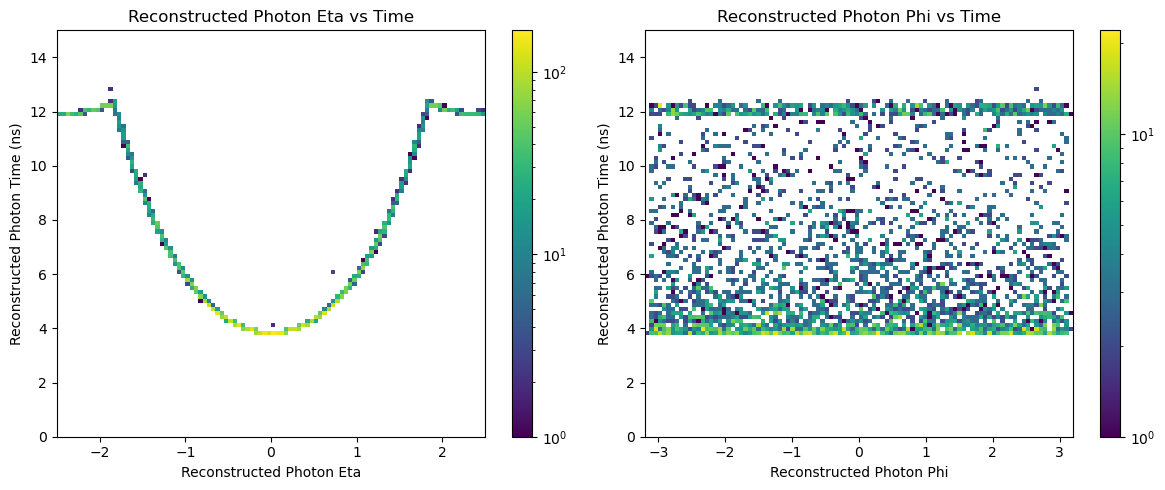

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
h1 = ax[0].hist2d(df["photon_eta"], df["photon_t"], bins=(100, 100), range=[[-2.5, 2.5], [0, 15]], cmap="viridis", norm=LogNorm())
ax[0].set_xlabel("Reconstructed Photon Eta")
ax[0].set_ylabel("Reconstructed Photon Time (ns)")
ax[0].set_title("Reconstructed Photon Eta vs Time")
fig.colorbar(h1[3], ax=ax[0])
h2 = ax[1].hist2d(df["photon_phi"], df["photon_t"], bins=(100, 100), range=[[-3.2, 3.2], [0, 15]], cmap="viridis", norm=LogNorm())
ax[1].set_xlabel("Reconstructed Photon Phi")
ax[1].set_ylabel("Reconstructed Photon Time (ns)")
ax[1].set_title("Reconstructed Photon Phi vs Time")
fig.colorbar(h2[3], ax=ax[1])
plt.tight_layout()
plt.savefig("prompt_half_dark_plots/reco_photon_eta_phi_vs_time.png")

In [6]:
# Convert eta to numeric (float) to avoid object-dtype dispatch issues, then compute theta
eta_vals = pd.to_numeric(df["photon_eta"], errors="coerce").astype(float)
theta = 2 * np.arctan(np.exp(-eta_vals))
r = pd.to_numeric(df["photon_t"] * .299792458, errors="coerce").astype(float)
det_r = r * np.sin(theta)
det_z = r * np.cos(theta)
det_z.min(), det_z.max(), det_r.min(), det_r.max()

(np.float64(-7.205669906758532),
 np.float64(4.223307073504519),
 np.float64(0.581534688782931),
 np.float64(5.402724127061054))

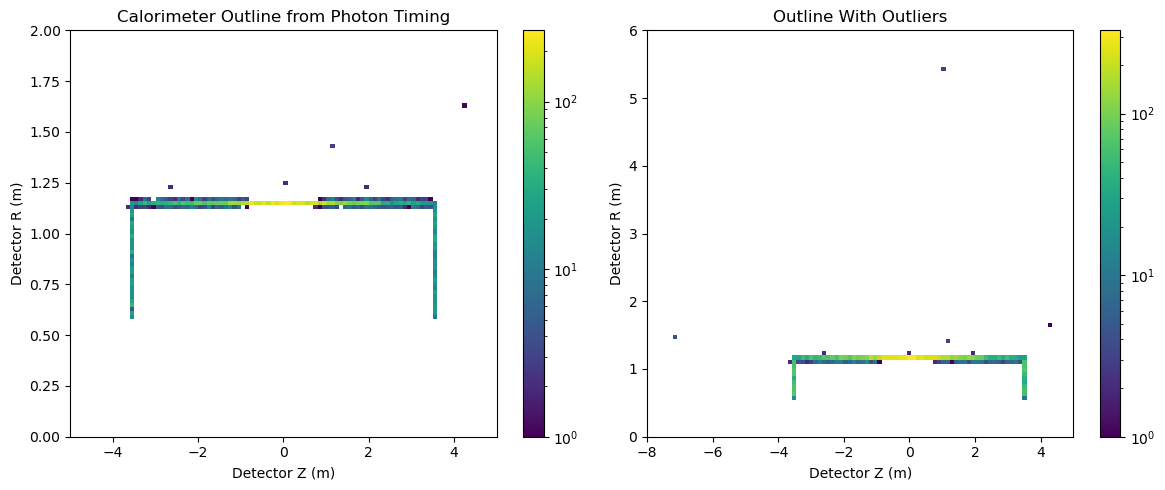

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
h1 = ax[0].hist2d(det_z, det_r, bins=(100, 100), range=[[-5, 5], [0, 2]], cmap="viridis", norm=LogNorm())
ax[0].set_xlabel("Detector Z (m)")
ax[0].set_ylabel("Detector R (m)")
ax[0].set_title("Calorimeter Outline from Photon Timing")
fig.colorbar(h1[3], ax=ax[0])
h2 = ax[1].hist2d(det_z, det_r, bins=(100, 100), range=[[-8, 5], [0, 6]], cmap="viridis", norm=LogNorm())
ax[1].set_xlabel("Detector Z (m)")
ax[1].set_ylabel("Detector R (m)")
ax[1].set_title("Outline With Outliers")
fig.colorbar(h2[3], ax=ax[1])
plt.tight_layout()
plt.savefig("prompt_half_dark_plots/calo_outline.png")

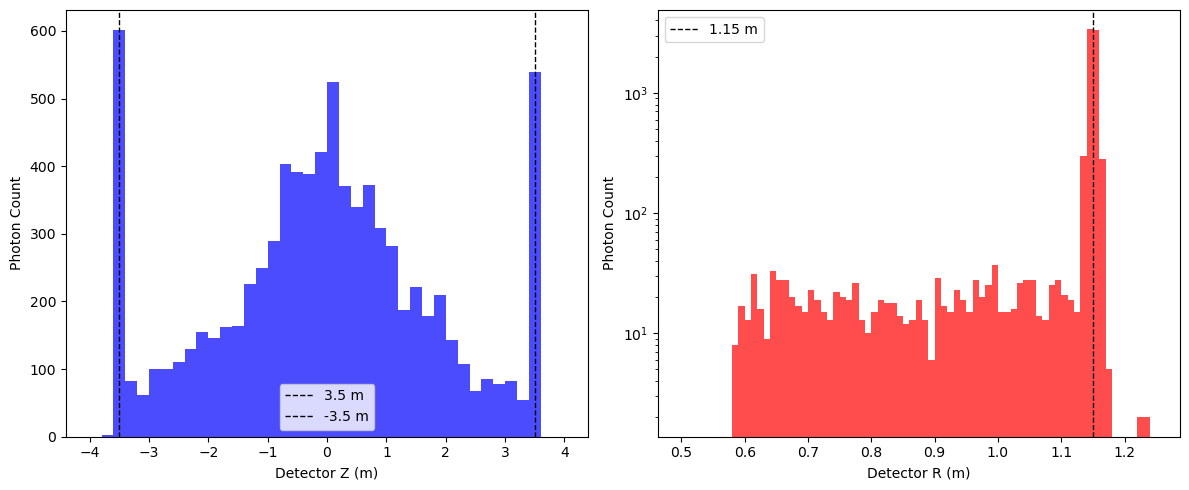

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(det_z, bins=40, range=(-4, 4), histtype='stepfilled', color='blue', alpha=0.7)
ax[0].set_xlabel("Detector Z (m)")
ax[0].set_ylabel("Photon Count")
ax[0].axvline(x=3.5, color='k', linestyle='dashed', linewidth=1, label='3.5 m')
ax[0].axvline(x=-3.5, color='k', linestyle='dashed', linewidth=1, label='-3.5 m')
ax[0].legend()
ax[1].hist(det_r, bins=75, range=(0.5, 1.25), histtype='stepfilled', color='red', alpha=0.7)
ax[1].set_xlabel("Detector R (m)")
ax[1].set_ylabel("Photon Count")
ax[1].axvline(x=1.15, color='k', linestyle='dashed', linewidth=1, label='1.15 m')
ax[1].legend()
ax[1].set_yscale('log')
plt.tight_layout()
plt.savefig("prompt_half_dark_plots/calo_zr_dist.png")